In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show

from model import Model

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
## Generate data
input_dim, output_dim = 1, 1

dy2 = 0
inputs = np.array([[-1], [1]])
outputs = np.array(
    [[1] + [1] * (output_dim - 1), [1 + (np.sqrt(dy2 / 2))] + [1] * (output_dim - 1)]
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]
val_dataset = [data]

tracked_datasets = val_dataset + train_datasets

In [3]:
gain = 1.6
P = 50
L = 10

In [4]:
def compute_D0_red(non_linearity, lr, N):
    reductions = []
    y0s, h0s = [], []
    gain_min = 1.6
    gain_max = 1.6
    gains = []

    for n in trange(N):
        # for gain in tqdm(np.linspace(gain_min, gain_max, N)):
        ## Instantiate model
        model = Model(
            encoding=encoding,
            input_size=inputs.shape[1],
            output_size=outputs.shape[1],
            hidden_dim=P,
            n_hid_layers=L,
            device=device,
            init_std=gain,
            non_linearity=non_linearity,
        )
        # Define Loss, Optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        compiler = Compiler(model, criterion, optimizer)

        # Compute initial difference
        h = get_activations(
            val_dataset, lambda inputs: model(inputs)[1][int(len(model) / 2)], encoding
        )
        h_A, h_B = h.loc[0, "A"].to_numpy(), h.loc[0, "B"].to_numpy()
        h_initial = np.sum((h_B - h_A) ** 2)
        y = get_activations(val_dataset, lambda inputs: model(inputs)[0], encoding)
        y_A, y_B = y.loc[0, "A"].to_numpy(), y.loc[0, "B"].to_numpy()
        y_initial = np.sum((y_B - y_A) ** 2)

        ## Training run
        with io.capture_output() as captured:
            compiler.training_run(
                train_datasets, tracked_datasets, n_epochs=300, batch_size=100
            )

        # Compute final difference
        h = get_activations(
            val_dataset, lambda inputs: model(inputs)[1][int(len(model) / 2)], encoding
        )
        h_A, h_B = h.loc[0, "A"].to_numpy(), h.loc[0, "B"].to_numpy()
        h_final = np.sum((h_B - h_A) ** 2)

        train_loss = compiler.validation(train_datasets)[0][0]
        if train_loss < 0.001:
            reduction = h_final / h_initial
            reductions.append(reduction)
            y0s.append(y_initial)
            h0s.append(h_initial)
            gains.append(gain)

    return h0s, y0s, reductions, gains

In [5]:
N = 10
h0s, y0s, reductions, gains = compute_D0_red(
    torch.nn.functional.leaky_relu, 0.03 * output_dim / P, N=N
)
# h0s, y0s, reductions, gains = compute_D0_red(
#     torch.nn.functional.sigmoid, 10 * output_dim / P, N=N
# )
# h0s, y0s, reductions, gains = compute_D0_red(
#     torch.nn.functional.elu, 0.003 * output_dim / P, N=N
# )
# h0s, y0s, reductions, gains = compute_D0_red(
#     torch.nn.functional.softplus, 0.03 * output_dim / P, N=N
# )

print(f"{len(h0s)} out of {N} converged")

100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]

999 out of 1000 converged


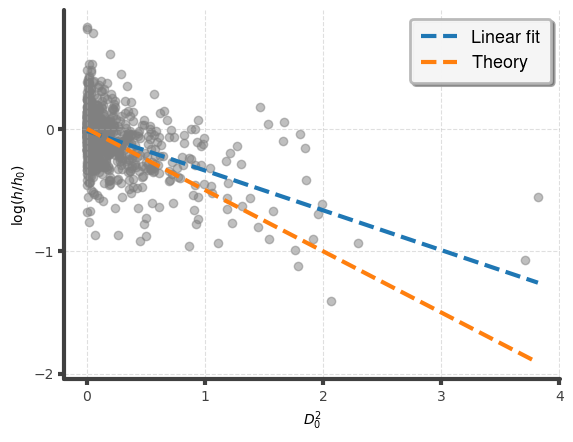

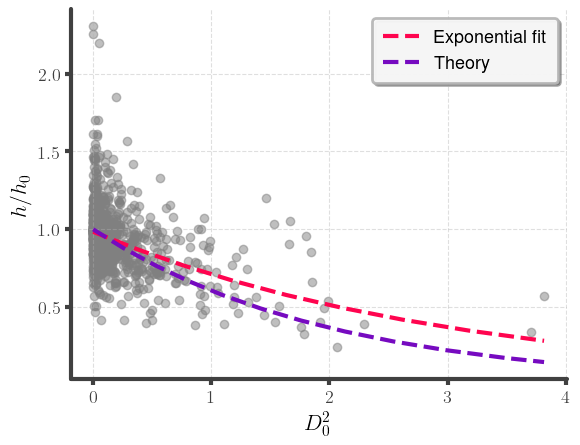

In [6]:
from data_analysis.visualization.publication import pub_show

x = np.array(y0s) / np.array(h0s)
y = np.log(reductions)

# D0_cutoff = 1
# y = y[x < D0_cutoff]
# x = x[x < D0_cutoff]

regr = scipy.stats.linregress(x, y)
a, b = regr.slope, regr.intercept
X = np.linspace(np.min(x), np.max(x), 300)

plt.scatter(x, y)
plt.xlabel("$D_0^2$")
plt.ylabel("$\log(h / h_0)$")
plt.plot(X, a * X + b, linestyle="--", label="Linear fit")
plt.plot(X, -0.5 * X, linestyle="--", label="Theory")
plt.legend()
# plt.show()
pub_show(colors="contrast")


y = np.exp(y)

plt.scatter(x, y)
plt.xlabel("$D_0^2$")
plt.ylabel("$h / h_0$")
plt.plot(X, np.exp(a * X + b), linestyle="--", label="Exponential fit")
plt.plot(X, np.exp(-0.5 * X), linestyle="--", label="Theory")
# plt.ylim([0, 1.5 * np.max(y)])
plt.legend()
# plt.show()

pub_show(colors="contrast")

In [161]:
alpha=0.1
color = "w"

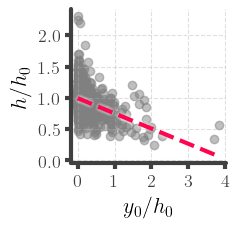

In [162]:
fig = plt.figure(figsize=(2, 2))

x = np.array(y0s) / np.array(h0s)
y = np.array(reductions)

# cutoff = 1.0
# y = y[x < cutoff]
# x = x[x < cutoff]

regr = scipy.stats.linregress(x, y)
a, b = regr.slope, regr.intercept
X = np.linspace(np.min(x), np.max(x), 300)

plt.scatter(x, y)
plt.xlabel("$y_0/h_0$")
plt.ylabel("$h / h_0$")
plt.plot(
    X,
    a * X + b,
    linestyle="--",
    path_effects=[
        pe.SimpleLineShadow(linewidth=4, offset=(1.4, 0), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(-1.4, 0), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(0, -1.4), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(0, 1.4), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(1, 1), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(-1, 1), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(1, -1), alpha=alpha, foreground=color),
        pe.SimpleLineShadow(linewidth=4, offset=(-1, -1), alpha=alpha, foreground=color),
        pe.Normal(),
    ],
)

# plt.legend()
# plt.ylim(0)
# plt.show()
pub_show(colors="contrast")

In [8]:
fig = plt.figure(figsize=(2, 2))

x = np.array(gains)
y = np.array(reductions)

# cutoff = 1.0
# y = y[x < cutoff]
# x = x[x < cutoff]

regr = scipy.stats.linregress(x, y)
a, b = regr.slope, regr.intercept
X = np.linspace(np.min(x), np.max(x), 300)

plt.scatter(x, y)
plt.xlabel("$gain$")
plt.ylabel("$h / h_0$")
plt.plot(X, a * X + b, linestyle="--", label="Linear fit")
plt.legend()
# plt.show()
pub_show(colors="contrast")

ValueError: Cannot calculate a linear regression if all x values are identical

<Figure size 200x200 with 0 Axes>